In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_from_disk
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from argparse import Namespace

In [2]:
config = {
    "train_subset": 1500000,
    "valid_subset": 400000,
    "test_subset" : 200000,
    "seed": 42
}

args = Namespace(**config)

### Read the dataset

In [3]:
violence_hidden = load_from_disk("../../Violence_data/geo_corpus.0.0.1_datasets_hidden_small_labse")

In [4]:
violence_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16769932
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 4192483
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2329158
    })
})

In [5]:
# Remove unncesary columns
keep_cols = ['hidden_state', 'labels']
remove_columns = [col for col in violence_hidden['train'].column_names if col not in keep_cols]

In [6]:
violence_hidden = violence_hidden.remove_columns(remove_columns)

In [7]:
violence_hidden

DatasetDict({
    train: Dataset({
        features: ['labels', 'hidden_state'],
        num_rows: 16769932
    })
    validation: Dataset({
        features: ['labels', 'hidden_state'],
        num_rows: 4192483
    })
    test: Dataset({
        features: ['labels', 'hidden_state'],
        num_rows: 2329158
    })
})

In [8]:
# Extract a subset of the dataset
train_clf_ds = violence_hidden["train"].shuffle(args.seed).select(range(args.train_subset))
validation_clf_ds = violence_hidden["validation"].shuffle(args.seed).select(range(args.valid_subset))
test_clf_ds = violence_hidden["test"].shuffle(args.seed).select(range(args.test_subset))

In [ ]:
train_clf_ds[0]

### Create a feature matrix

In [9]:
%time X_train = np.array(train_clf_ds["hidden_state"])
y_train = np.array(train_clf_ds["labels"])
X_validation = np.array(validation_clf_ds["hidden_state"])
y_validation = np.array(validation_clf_ds["labels"])
X_test = np.array(test_clf_ds["hidden_state"])
y_test = np.array(test_clf_ds["labels"])
X_train.shape

CPU times: user 25.5 s, sys: 17.6 s, total: 43 s
Wall time: 29 s


(1500000, 768)

In [ ]:
print(np.min(X_train[10]))
print(np.max(X_train[10]))

## Helper Functions

In [10]:
# Create a function to report the various metrics for each classifier
def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)
    
    roc_auc = roc_auc_score(test_labels, predictions, average = "micro")

    weighted_precision = precision_score(test_labels, predictions, average='weighted')
    weighted_recall = recall_score(test_labels, predictions, average='weighted')
    weighted_f1 = f1_score(test_labels, predictions, average='weighted')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    
    
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nroc_auc_score: {:.4f}\nPrecision:\n  - Weighted: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Weighted: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Weighted: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, roc_auc, weighted_precision, micro_precision, weighted_recall, micro_recall, weighted_f1, micro_f1))
    ModelsPerformance[modelName] = {"accuracy": format(accuracy, '.4f'), "roc_auc": format(roc_auc, '.4f'), "weighted_precision": format(weighted_precision, '.4f'),
                                    "weighted_recall": format(weighted_recall, '.4f'), "weighted_f1": format(weighted_f1, '.4f'), "micro_precision": format(micro_precision, '.4f'),
                                    "micro_recall": format(micro_recall, '.4f'), "micro_f1": format(micro_f1, '.4f')}

In [11]:
def plot_confusion_matrix(y_test, y_pred, clf:str):
    f, axes = plt.subplots(2, 3, figsize=(25, 15))
    f.suptitle(clf, fontsize=36)
    axes = axes.ravel()
    for i in range(6):
        labels=['post7geo10', 'post7geo30', 'post7geo50','pre7geo10','pre7geo30', 'pre7geo50']
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                       y_pred[:, i]),
                                      display_labels=[0, i])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_title(labels[i])
        if i<10:
            disp.ax_.set_xlabel('')
        if i%5!=0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()

# Classifiers

## Problem transformation

### Bagging

In [12]:
bagClassifier = OneVsRestClassifier(BaggingClassifier(n_jobs=-1, 
                                                      random_state=args.seed))
%time bagClassifier.fit(X_train, y_train)


CPU times: user 8.77 s, sys: 13.9 s, total: 22.7 s
Wall time: 5h 11min 1s


OneVsRestClassifier(estimator=BaggingClassifier(n_jobs=-1, random_state=42))

In [13]:
%time bagPreds = bagClassifier.predict(X_test)

CPU times: user 1.33 s, sys: 2.84 s, total: 4.17 s
Wall time: 26.5 s


### Boosting

In [21]:
boostClassifier = OneVsRestClassifier(GradientBoostingClassifier(
    random_state=args.seed), n_jobs=-1)
%time boostClassifier.fit(X_train, y_train)

CPU times: user 7.42 s, sys: 21.4 s, total: 28.8 s
Wall time: 21h 58min 53s


OneVsRestClassifier(estimator=GradientBoostingClassifier(random_state=42),
                    n_jobs=-1)

In [22]:
%time boostPreds = boostClassifier.predict(X_test)

CPU times: user 9.14 s, sys: 51.6 ms, total: 9.2 s
Wall time: 9.18 s


### OneVsRest - Support Vector Machine

In [14]:
# Standardize the data for SVM
X_train_scaled = StandardScaler().fit_transform(X_train)
X_validation_scaled = StandardScaler().fit_transform(X_validation)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [ ]:
svmClassifier = OneVsRestClassifier(LinearSVC(
    random_state=args.seed, max_iter=7000, 
    dual=False, tol=1e-5), n_jobs=-1)
%time svmClassifier.fit(X_train_scaled, y_train)

In [ ]:
%time svmPreds = svmClassifier.predict(X_test)

### Binary Relevance - Support Vector Machine

In [15]:
BinaryRelSVC = BinaryRelevance(LinearSVC(random_state=args.seed,
                                         max_iter=7000, dual=False, 
                                         tol=1e-5),
                                         require_dense = [True, True])
%time BinaryRelSVC.fit(X_train_scaled, y_train)

CPU times: user 5h 1min 39s, sys: 1h 12min 2s, total: 6h 13min 42s
Wall time: 6h 13min 41s


BinaryRelevance(classifier=LinearSVC(dual=False, max_iter=7000, random_state=42,
                                     tol=1e-05),
                require_dense=[True, True])

In [16]:
%time BinRelSVCPreds = BinaryRelSVC.predict(X_test).toarray()

CPU times: user 6.4 s, sys: 14.8 s, total: 21.2 s
Wall time: 3.59 s


## Problem Adaptation

### Decision Trees

In [17]:
dtClassifier = DecisionTreeClassifier(random_state=args.seed)
%time dtClassifier.fit(X_train, y_train)

CPU times: user 1h 34min 34s, sys: 17.1 s, total: 1h 34min 51s
Wall time: 1h 34min 48s


DecisionTreeClassifier(random_state=42)

In [18]:
%time dtPreds = dtClassifier.predict(X_test)

CPU times: user 422 ms, sys: 27.4 ms, total: 449 ms
Wall time: 446 ms


### Random Forest

In [19]:
rfClassifier = RandomForestClassifier(n_jobs=-1, 
                                      random_state=args.seed)
%time rfClassifier.fit(X_train, y_train)

CPU times: user 4h 27min 6s, sys: 40 s, total: 4h 27min 46s
Wall time: 6min 56s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [20]:
%time rfPreds = rfClassifier.predict(X_test)

CPU times: user 49.7 s, sys: 13.4 s, total: 1min 3s
Wall time: 3.1 s


# Model Evaluation

### Evaluate classifiers

In [23]:
ModelsPerformance = {}
metricsReport("Bagging", y_test, bagPreds)
metricsReport("Boosting", y_test, boostPreds)
# metricsReport("SVM-OVR", y_test, svmPreds)
metricsReport("SVM-BR", y_test, BinRelSVCPreds)
metricsReport("Decision Tree", y_test, dtPreds)
metricsReport("Random Forest", y_test, rfPreds)


------Bagging Model Metrics-----
Accuracy: 0.0682
roc_auc_score: 0.5564
Precision:
  - Weighted: 0.5186
  - Micro: 0.5397
Recall:
  - Weighted: 0.4094
  - Micro: 0.4094
F1-measure:
  - Weighted: 0.4475
  - Micro: 0.4656
------Boosting Model Metrics-----
Accuracy: 0.0429
roc_auc_score: 0.5845
Precision:
  - Weighted: 0.6118
  - Micro: 0.5698
Recall:
  - Weighted: 0.4712
  - Micro: 0.4712
F1-measure:
  - Weighted: 0.3903
  - Micro: 0.5159


/home/mmendieta/transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------SVM-BR Model Metrics-----
Accuracy: 0.0944
roc_auc_score: 0.5168
Precision:
  - Weighted: 0.2906
  - Micro: 0.6015
Recall:
  - Weighted: 0.0769
  - Micro: 0.0769
F1-measure:
  - Weighted: 0.0953
  - Micro: 0.1364
------Decision Tree Model Metrics-----
Accuracy: 0.1489
roc_auc_score: 0.5393
Precision:
  - Weighted: 0.4992
  - Micro: 0.5020
Recall:
  - Weighted: 0.4991
  - Micro: 0.4991
F1-measure:
  - Weighted: 0.4990
  - Micro: 0.5006
------Random Forest Model Metrics-----
Accuracy: 0.0725
roc_auc_score: 0.5902
Precision:
  - Weighted: 0.5705
  - Micro: 0.5728
Recall:
  - Weighted: 0.4923
  - Micro: 0.4923
F1-measure:
  - Weighted: 0.4515
  - Micro: 0.5295


In [24]:
print(" Model Name " + " "*3 + "| Acc.   " + " "*1 + "| ROC_AUC " + " "*1 + "| weighted_prec" + " "*1 + "| weighted_rec" + " "*1 + "| weighted_f1" + " "*1 + "| micro_prec" + " "*1 + "| micro_rec" + " "*1 + "| micro_f1")
print("--------------------------------------------------------------------------------------------------------------------")
for key, value in ModelsPerformance.items():
    print(" " + key, " "*(13-len(key)) + "|", value["accuracy"], " "*(1) + "|", value["roc_auc"], " "*(2) + "|", value["weighted_precision"], " "*(7) + "|", value["weighted_recall"], " "*(6) + "|", value["weighted_f1"], " "*(5) + "|", value["micro_precision"], " "*(4) + "|", value["micro_recall"], " "*(3) + "|", value["micro_f1"])
    print("--------------------------------------------------------------------------------------------------------------------")

 Model Name    | Acc.    | ROC_AUC  | weighted_prec | weighted_rec | weighted_f1 | micro_prec | micro_rec | micro_f1
--------------------------------------------------------------------------------------------------------------------
 Bagging       | 0.0682  | 0.5564   | 0.5186        | 0.4094       | 0.4475      | 0.5397     | 0.4094    | 0.4656
--------------------------------------------------------------------------------------------------------------------
 Boosting      | 0.0429  | 0.5845   | 0.6118        | 0.4712       | 0.3903      | 0.5698     | 0.4712    | 0.5159
--------------------------------------------------------------------------------------------------------------------
 SVM-BR        | 0.0944  | 0.5168   | 0.2906        | 0.0769       | 0.0953      | 0.6015     | 0.0769    | 0.1364
--------------------------------------------------------------------------------------------------------------------
 Decision Tree | 0.1489  | 0.5393   | 0.4992        | 0.4991       | 0

In [ ]:
# Optional
print(classification_report(rfPreds, y_test, target_names=['post7geo10', 'post7geo30', 'post7geo50',
                                                     'pre7geo10','pre7geo30', 'pre7geo50']))

### Plot Confusion Matrix

In [ ]:
# Bagging Classifier
plot_confusion_matrix(y_test, bagPreds, "Bagging Classifier")

In [ ]:
# Boosting Classifier
plot_confusion_matrix(y_test, boostPreds, "Boosting Classifier")

In [ ]:
# SVM-OVR Classifier
plot_confusion_matrix(y_test, svmPreds, "SVM - One vs Rest")

In [ ]:
# SVM - Binary Relevance Classifier
plot_confusion_matrix(y_test, BinRelSVCPreds, "SVM - Binary Relevance")

In [ ]:
# Decision Trees Classifier
plot_confusion_matrix(y_test, dtPreds, "Decision Tree")

In [ ]:
# Random Forest Classifier
plot_confusion_matrix(y_test, rfPreds, "Random Forest Classifier")

### Plot ROC Curve for the best classifier

/home/mmendieta/transformers/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/mmendieta/transformers/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/mmendieta/transformers/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc

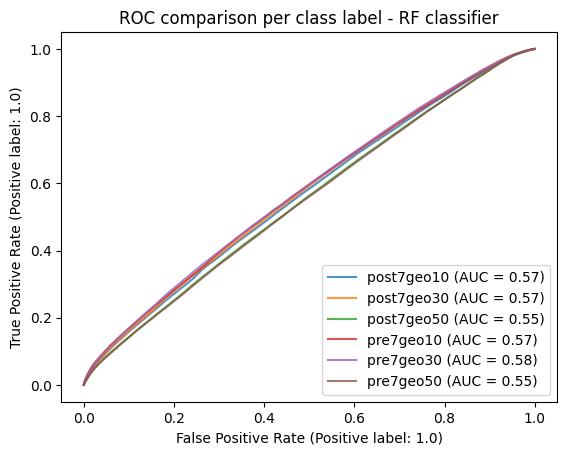

In [25]:
# Plot ROC Curve for the best classifier (RF)
label_names = ['post7geo10', 'post7geo30', 'post7geo50', 'pre7geo10','pre7geo30', 'pre7geo50']
labelPlots ={}
for i in range (len(label_names)):
    rfClassifier.fit(X_train, y_train[:,i])
    ax = plt.gca()
    labelPlots[i]= plot_roc_curve(rfClassifier, X_test, y_test[:,i], name= label_names[i], ax=ax, alpha=0.8) 

plt.title("ROC comparison per class label - RF classifier")
plt.show()